In [1]:
%load_ext autoreload
%autoreload 2

Here we import key libraries used in the notebook (run `uv sync` and select the corresponding kernel if some of them are missing).

In [2]:
# Main libraries
import shap
import numpy as np
import os

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# We will use Polars for data manipulation
import polars as pl

# Casting types from time to time to have a better autocompletion
from typing import cast

from models import train_and_explain, ExperimentResults, Species, ModelType

from config import Ablation

# Use caching for various results
if not os.path.exists("./cache"):
    os.makedirs("./cache")

/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We then optimize hyperparameters and train models for every species. We may also select here the type of grouping used by the K-fold validation.

Now configure the model to be used and the grouping column for K-fold validation.

In [3]:
# Predict the mean of the distribution
group_col = "tree_id"  # "tree_id" or "plot_id"
model_type: ModelType = "lgbm"  # "lgbm" or "lasso"
ablation: Ablation = "no-defoliation"  # "all", "tree-level-only", "plot-level-only", "no-defoliation", "max-defoliation"

all_species: list[Species] = ["spruce", "pine", "beech", "oak"]
all_results: dict[Species, ExperimentResults] = {}

for species in all_species:
    all_results[species] = train_and_explain(
        species, model_type=model_type, group_by=group_col, ablation=ablation
    )

2025-07-09 16:24:51 - INFO - Loading cached study for spruce with group_col=tree_id.


Training model for spruce
KS Statistic: 0.020209514794737704
P-value: 1.5e-05
Starting cross-validation for spruce with lgbm estimator...
Fold 1/5


2025-07-09 16:24:53 - INFO - Loading cached study for spruce with group_col=tree_id.


Fold 1: R2 (train) = 0.51, R2 (test) = 0.49
Fold 2/5


2025-07-09 16:24:54 - INFO - Loading cached study for spruce with group_col=tree_id.


Fold 2: R2 (train) = 0.52, R2 (test) = 0.47
Fold 3/5


2025-07-09 16:24:56 - INFO - Loading cached study for spruce with group_col=tree_id.


Fold 3: R2 (train) = 0.53, R2 (test) = 0.45
Fold 4/5


2025-07-09 16:24:58 - INFO - Loading cached study for spruce with group_col=tree_id.


Fold 4: R2 (train) = 0.52, R2 (test) = 0.46
Fold 5/5
Fold 5: R2 (train) = 0.52, R2 (test) = 0.46
Cross-validation completed for spruce with lgbm estimator.
Summary of results:
 `- R2 (test): 0.47 +/- 0.01
 `- R2 (train): 0.52 +/- 0.00


2025-07-09 16:25:42 - INFO - Loading cached study for pine with group_col=tree_id.


Training model for pine
KS Statistic: 0.022099147849490075
P-value: 0.00022
Starting cross-validation for pine with lgbm estimator...
Fold 1/5


2025-07-09 16:25:43 - INFO - Loading cached study for pine with group_col=tree_id.


Fold 1: R2 (train) = 0.48, R2 (test) = 0.44
Fold 2/5


2025-07-09 16:25:43 - INFO - Loading cached study for pine with group_col=tree_id.


Fold 2: R2 (train) = 0.48, R2 (test) = 0.42
Fold 3/5


2025-07-09 16:25:44 - INFO - Loading cached study for pine with group_col=tree_id.


Fold 3: R2 (train) = 0.49, R2 (test) = 0.38
Fold 4/5


2025-07-09 16:25:44 - INFO - Loading cached study for pine with group_col=tree_id.


Fold 4: R2 (train) = 0.48, R2 (test) = 0.41
Fold 5/5
Fold 5: R2 (train) = 0.47, R2 (test) = 0.44
Cross-validation completed for pine with lgbm estimator.
Summary of results:
 `- R2 (test): 0.42 +/- 0.02
 `- R2 (train): 0.48 +/- 0.00


2025-07-09 16:25:49 - INFO - Loading cached study for beech with group_col=tree_id.


Training model for beech
KS Statistic: 0.02683862205735274
P-value: 7.1e-05
Starting cross-validation for beech with lgbm estimator...
Fold 1/5


2025-07-09 16:25:50 - INFO - Loading cached study for beech with group_col=tree_id.


Fold 1: R2 (train) = 0.50, R2 (test) = 0.43
Fold 2/5


2025-07-09 16:25:50 - INFO - Loading cached study for beech with group_col=tree_id.


Fold 2: R2 (train) = 0.49, R2 (test) = 0.47
Fold 3/5


2025-07-09 16:25:51 - INFO - Loading cached study for beech with group_col=tree_id.


Fold 3: R2 (train) = 0.50, R2 (test) = 0.45
Fold 4/5


2025-07-09 16:25:51 - INFO - Loading cached study for beech with group_col=tree_id.


Fold 4: R2 (train) = 0.50, R2 (test) = 0.45
Fold 5/5
Fold 5: R2 (train) = 0.50, R2 (test) = 0.44
Cross-validation completed for beech with lgbm estimator.
Summary of results:
 `- R2 (test): 0.45 +/- 0.01
 `- R2 (train): 0.50 +/- 0.00


2025-07-09 16:25:57 - INFO - Loading cached study for oak with group_col=tree_id.


Training model for oak
KS Statistic: 0.03137785028353701
P-value: 0.012
Starting cross-validation for oak with lgbm estimator...
Fold 1/5


2025-07-09 16:25:58 - INFO - Loading cached study for oak with group_col=tree_id.


Fold 1: R2 (train) = 0.46, R2 (test) = 0.29
Fold 2/5


2025-07-09 16:25:58 - INFO - Loading cached study for oak with group_col=tree_id.


Fold 2: R2 (train) = 0.46, R2 (test) = 0.32
Fold 3/5


2025-07-09 16:25:59 - INFO - Loading cached study for oak with group_col=tree_id.


Fold 3: R2 (train) = 0.43, R2 (test) = 0.43
Fold 4/5


2025-07-09 16:25:59 - INFO - Loading cached study for oak with group_col=tree_id.


Fold 4: R2 (train) = 0.44, R2 (test) = 0.38
Fold 5/5
Fold 5: R2 (train) = 0.46, R2 (test) = 0.28
Cross-validation completed for oak with lgbm estimator.
Summary of results:
 `- R2 (test): 0.34 +/- 0.06
 `- R2 (train): 0.45 +/- 0.01


## Evaluate model performance for each species

Here we compute the mean and standard deviation of the $R^2$ (coefficient of determination) for all species and folds.

In [4]:
def check_significance(r2: str, k: int = 5) -> str:
    """Check if the R2 value is significant."""
    from scipy import stats

    # Split the R2 value of the form "0.307 ± 0.02"
    r2_value, r2_error = r2.split(" ± ")

    # Perform a t-test to check if the R2 value is significantly positive
    standard_error = float(r2_error) / np.sqrt(k)
    t_statistic = float(r2_value) / standard_error

    # Calculate the p-value
    p_value = stats.t.sf(t_statistic, k - 1)

    if p_value < 0.001:
        return f"{r2_value} ± {r2_error}***"
    elif p_value < 0.01:
        return f"{r2_value} ± {r2_error}**"
    elif p_value < 0.05:
        return f"{r2_value} ± {r2_error}*"
    else:
        return f"{r2_value} ± {r2_error}"

In [5]:
import polars.selectors as cs

PERF_CSV = "./cache/performance_summary.csv"

PERF_KEYS = ["group_by", "model", "split", "ablation"]

perf = pl.concat(
    [
        pl.from_dicts(results.performances).select(
            pl.lit(species).alias("species"),
            pl.first().cum_count().alias("fold"),
            "test_r2",
            "train_r2",
        )
        for species, results in all_results.items()
    ],
    how="vertical",
)

perf = (
    perf.group_by("species")
    .agg(
        pl.mean("test_r2").alias("mean_test_r2"),
        pl.std("test_r2").alias("std_test_r2"),
        pl.mean("train_r2").alias("mean_train_r2"),
        pl.std("train_r2").alias("std_train_r2"),
    )
    .select(
        "species",
        test=pl.col("mean_test_r2").round(3).cast(pl.Utf8)
        + " ± "
        + pl.col("std_test_r2").round(2).cast(pl.Utf8),
        train=pl.col("mean_train_r2").round(3).cast(pl.Utf8)
        + " ± "
        + pl.col("std_train_r2").round(2).cast(pl.Utf8),
    )
    .unpivot(index="species")
    .pivot(index="variable", on="species", values="value")
    .rename({"variable": "split"})
    .select(
        pl.lit(ablation).cast(pl.Utf8).alias("ablation"),
        pl.lit(model_type).cast(pl.Utf8).alias("model"),
        pl.lit(group_col).cast(pl.Utf8).alias("group_by"),
        "split",
        *all_species,
    )
)

if os.path.exists(PERF_CSV):
    perf = pl.concat([perf, pl.read_csv(PERF_CSV)], how="vertical").unique(
        subset=PERF_KEYS, keep="last"
    )

# Sort the performance DataFrame for better readability
perf = perf.sort(PERF_KEYS).select(
    cs.by_dtype(pl.Utf8).str.replace_all("+/-", "±", literal=True).name.keep()
)

perf.write_csv(PERF_CSV)

with pl.Config() as cfg:
    cfg.set_tbl_formatting("ASCII_MARKDOWN")
    cfg.set_tbl_width_chars(125)
    cfg.set_tbl_hide_column_data_types(True)

    for group_by in perf["group_by"].unique().sort():
        print(f"\nPerformance summary for group_by='{group_by}':")
        print(
            perf.filter(pl.col("group_by") == group_by)
            .filter(pl.col("split") != "train")
            .with_columns(
                mean_r2=pl.mean_horizontal(
                    cs.by_name("spruce", "pine", "beech", "oak")
                    .str.slice(0, 4)
                    .cast(pl.Float64)
                ).round(2),
            )
            .with_columns(
                cs.by_name("spruce", "pine", "beech", "oak").map_elements(
                    lambda x: check_significance(x, k=5), return_dtype=pl.Utf8
                )
            )
            .select(cs.all().exclude("group_by", "split"))
        )


Performance summary for group_by='plot_id':
shape: (7, 7)
| ablation        | model | spruce        | pine          | beech         | oak           | mean_r2 |
|-----------------|-------|---------------|---------------|---------------|---------------|---------|
| all             | lasso | 0.06 ± 0.03** | 0.063 ± 0.06* | -0.082 ± 0.18 | -0.144 ± 0.17 | 0.0     |
| plot-level-only | lasso | -0.047 ± 0.07 | 0.058 ± 0.04* | -0.227 ± 0.25 | -0.16 ± 0.15  | -0.06   |
| tree-level-only | lasso | 0.058 ± 0.07  | 0.012 ± 0.05  | 0.018 ± 0.05  | -0.06 ± 0.17  | 0.02    |
| all             | lgbm  | 0.15 ± 0.06** | 0.038 ± 0.15  | 0.01 ± 0.31   | -0.093 ± 0.11 | 0.05    |
| no-defoliation  | lgbm  | -0.016 ± 0.08 | 0.063 ± 0.13  | 0.019 ± 0.29  | -0.215 ± 0.25 | -0.03   |
| plot-level-only | lgbm  | -0.001 ± 0.08 | -0.009 ± 0.14 | -0.014 ± 0.2  | -0.126 ± 0.17 | -0.03   |
| tree-level-only | lgbm  | 0.038 ± 0.08  | -0.019 ± 0.08 | -0.018 ± 0.14 | -0.095 ± 0.16 | 0.01    |

Performance summary fo

/var/folders/8w/bgtq_bb95_bgd7nxmt9xj04h0000gn/T/ipykernel_3407/2454100660.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  t_statistic = float(r2_value) / standard_error


## Feature importance by species

Here we show how feature importance varies by species.

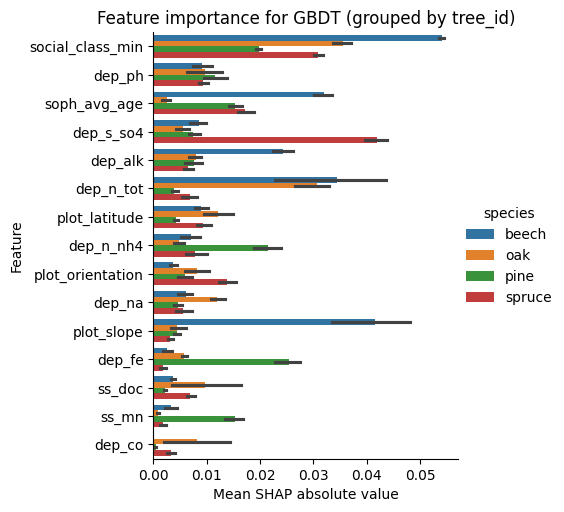

In [6]:
min_shap = 0.015
max_rank = 5

feature_importances = (
    pl.from_dicts(
        [
            {
                "species": species,
                "fold": fold,
                **dict(
                    zip(
                        results.features,
                        np.absolute(results.shap_values[fold].values).mean(axis=0),
                    )
                ),
            }
            for species, results in all_results.items()
            for fold in range(5)
        ]
    )
    .unpivot(
        on=cs.exclude("species", "fold"),  # type: ignore
        index=["species", "fold"],
        variable_name="feature",
        value_name="shap",
    )
    # .group_by("species", "feature")
    # .agg(pl.col("shap").mean().alias("shap"), pl.col("shap").std().alias("sd"))
    .with_columns(rank=pl.col("shap").rank(descending=True).over("species"))
    .with_columns(
        shap_max=pl.col("shap").max().over("feature"),
        min_rank=pl.col("rank").min().over("feature"),
    )
)

feature_importances.write_parquet(
    f"./cache/feature_importances-{ablation}-{model_type}-{group_col}.parquet",
)

data = feature_importances.filter(
    (pl.col("shap_max") > min_shap) | (pl.col("min_rank") <= 5)
).sort("species", pl.col("rank").mean().over("feature"), descending=[False, False])

g = sns.catplot(data, x="shap", y="feature", hue="species", kind="bar")

plt.xlabel("Mean SHAP absolute value")
plt.ylabel("Feature")

if model_type == "lgbm":
    plt.title(f"Feature importance for GBDT (grouped by {group_col})")
elif model_type == "lasso":
    plt.title(f"Feature importance for Lasso (grouped by {group_col})")

fig = plt.gcf()
plt.savefig(
    f"./figures/importance-{model_type}-{group_col}-{ablation}.pdf",
    bbox_inches="tight",
)

In [7]:
# Variation of feature importance with and without defoliation
top_n = 3

if os.path.exists(
    f"./cache/feature_importances-no-defoliation-{model_type}-{group_col}.parquet"
):
    importances_comparison = (
        feature_importances.join(
            pl.read_parquet(
                f"./cache/feature_importances-no-defoliation-{model_type}-{group_col}.parquet"
            ),
            on=["species", "feature"],
            suffix="-no-defoliation",
        )
        .group_by("species", "feature")
        .agg(
            pl.col("rank").mean().cast(pl.Int32).alias("rank-all-features"),
            pl.col("rank-no-defoliation")
            .mean()
            .cast(pl.Int32)
            .alias("rank-no-defoliation"),
            pl.col("shap").mean().alias("shap-all-features"),
            pl.col("shap-no-defoliation").mean().alias("shap-no-defoliation"),
        )
        .with_columns(
            shap_delta=pl.col("shap-no-defoliation") - pl.col("shap-all-features"),
            rank_delta=pl.col("rank-all-features") - pl.col("rank-no-defoliation"),
        )
        .filter(
            (
                pl.col("shap_delta").rank("dense", descending=True).over("species")
                <= top_n
            )
            & (pl.col("shap_delta") > 0)
        )
        .sort(["species", "shap_delta"], descending=[False, True])
    )

    with pl.Config() as cfg:
        cfg.set_tbl_formatting("ASCII_MARKDOWN")
        cfg.set_float_precision(3)
        cfg.set_tbl_rows(100)
        cfg.set_tbl_hide_column_data_types(True)

        print(importances_comparison)
        importances_comparison.write_clipboard(float_precision=3)

shape: (18, 8)
| species | feature    | rank-all-f | rank-no-de | shap-all-f | shap-no-de | shap_delt | rank_delt |
|         |            | eatures    | foliation  | eatures    | foliation  | a         | a         |
|---------|------------|------------|------------|------------|------------|-----------|-----------|
| beech   | social_cla | 3          | 3          | 0.054      | 0.054      | 0.000     | 0         |
|         | ss_min     |            |            |            |            |           |           |
| beech   | dep_p_po4  | 106        | 106        | 0.005      | 0.005      | 0.000     | 0         |
| beech   | ss_ph      | 108        | 108        | 0.005      | 0.005      | 0.000     | 0         |
| beech   | dep_ph     | 49         | 49         | 0.009      | 0.009      | 0.000     | 0         |
| beech   | ss_s_so4   | 85         | 85         | 0.008      | 0.008      | 0.000     | 0         |
| beech   | dep_k      | 69         | 69         | 0.007      | 0.007      |

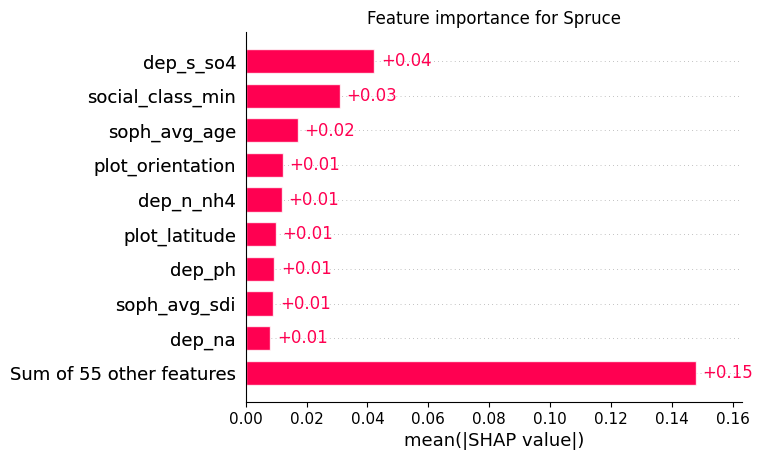

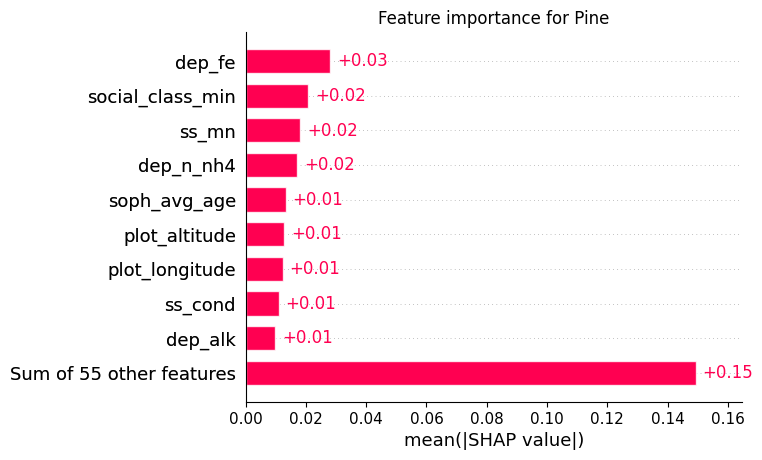

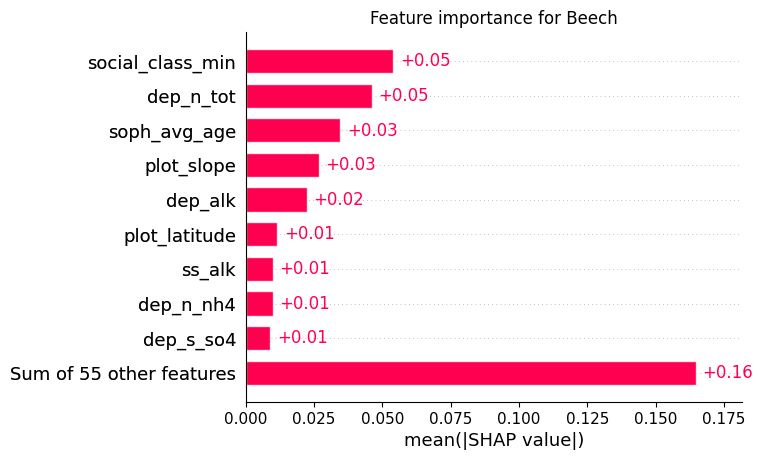

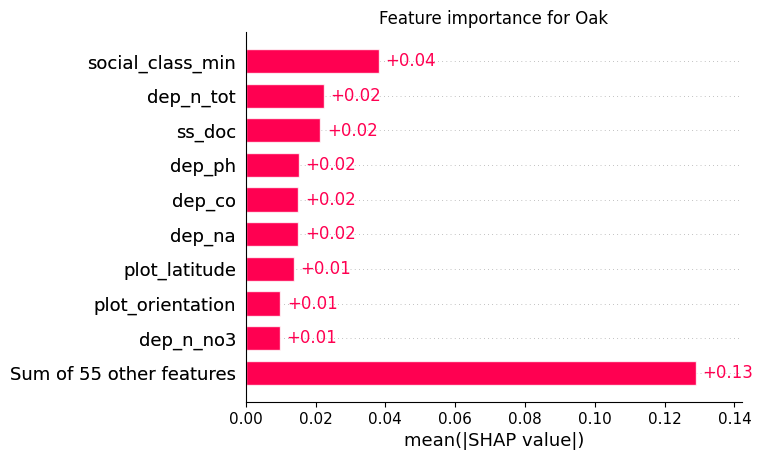

In [8]:
# Plot the top N features by species for a given fold
fold = 0  # Change this to plot for a different fold
for species, results in all_results.items():
    plt.figure()
    ax = shap.plots.bar(
        results.shap_values[fold],
        max_display=10,
        ax=plt.gca(),
        show=False,
    )
    ax.set_title(f"Feature importance for {species.capitalize()}")

## Feature dependence plots

These plots show how the Shapley value varies as a function of feature value.

Text(42.472222222222214, 0.5, 'SHAP value')

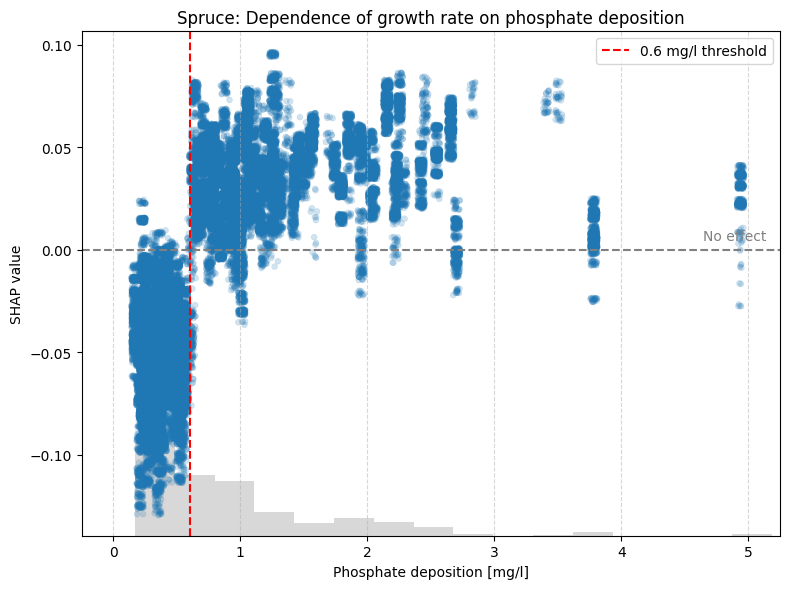

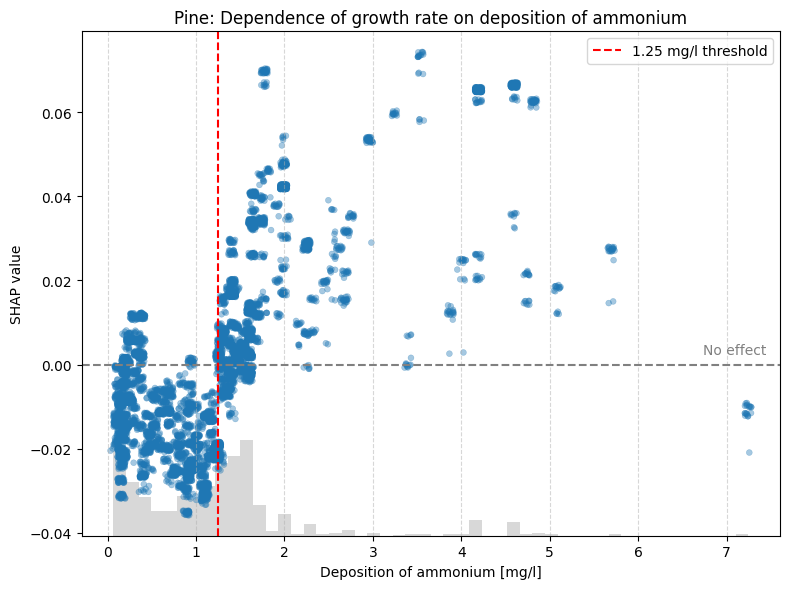

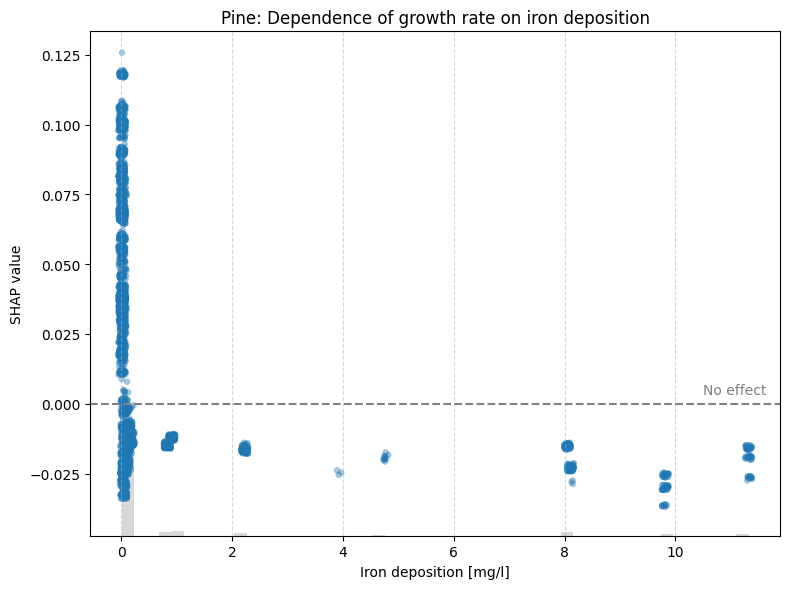

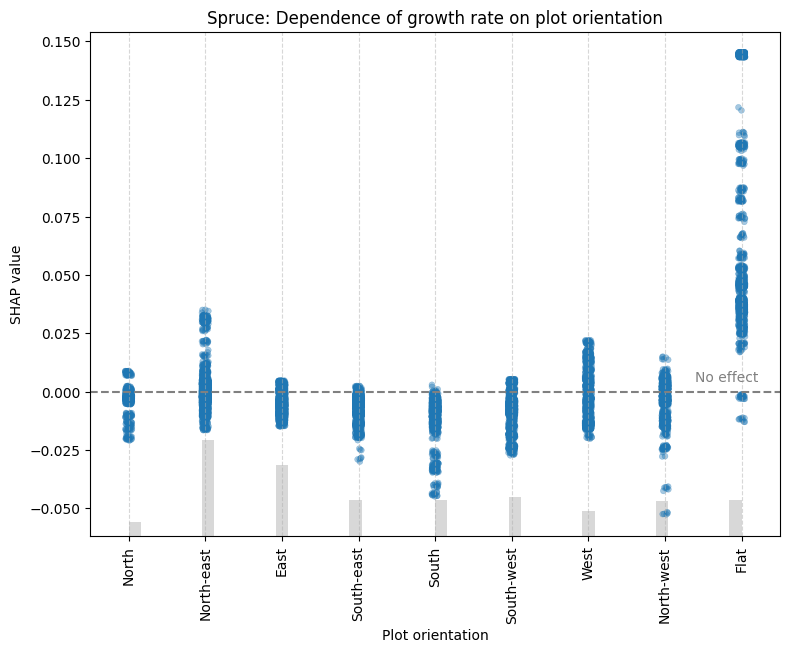

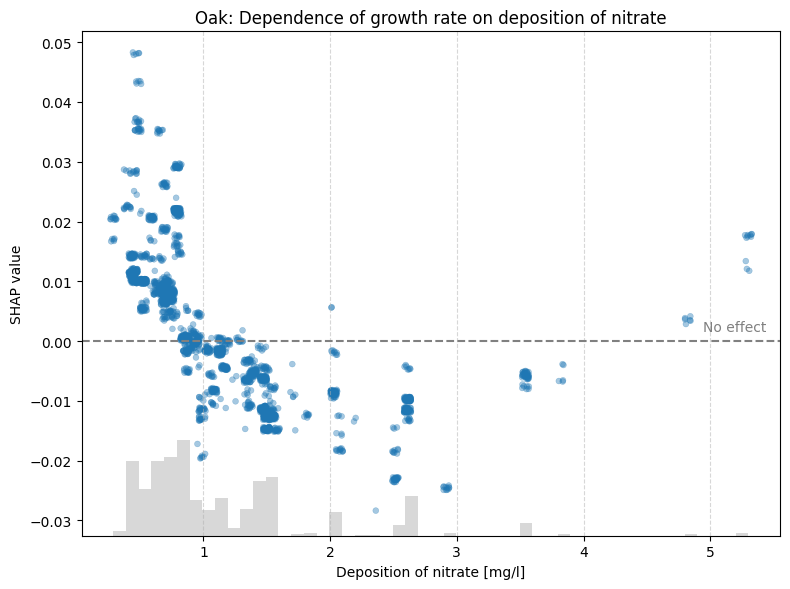

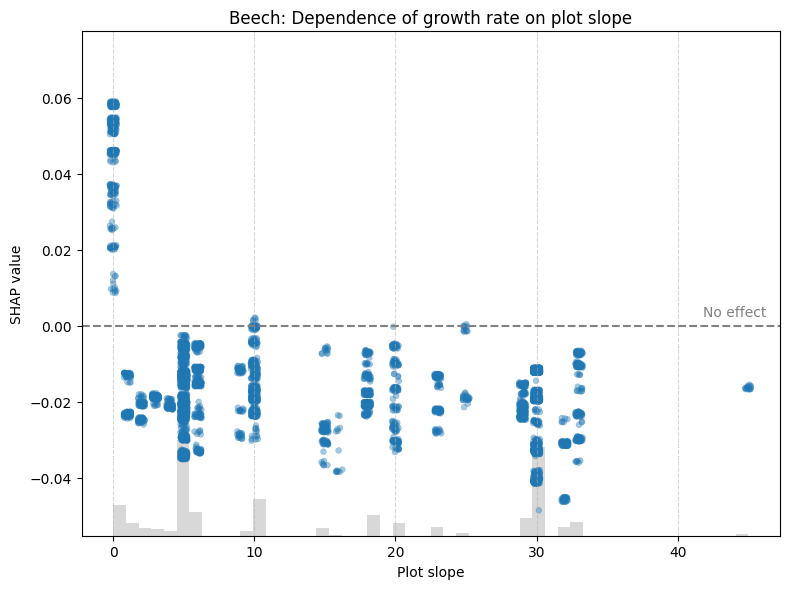

In [41]:
from explain import plot_dependence

# Produce dependence plots for some key (species, feature) pairs
fold = 0  # Change this to plot for a different fold

# Spruce: dependence on deposition of phosphate
ax = plot_dependence(all_results["spruce"], feature="dep_s_so4", xlim=(0, 5.0))
# Set a vertical line at 0.6 mg/l
ax.axvline(0.6, color="red", linestyle="--", label="0.6 mg/l threshold")
ax.legend()
ax.set_title("Spruce: Dependence of growth rate on phosphate deposition")
ax.set_xlabel("Phosphate deposition [mg/l]")
ax.set_ylabel("SHAP value")

# Pine: dependence on deposition of ammonium (dep_n_nh4)
ax = plot_dependence(
    all_results["pine"],
    feature="dep_n_nh4",
    fold=fold,
    show_interaction=True,
    alpha=0.4,
)
# Set a vertical line at 1.25 mg/l
ax.axvline(1.25, color="red", linestyle="--", label="1.25 mg/l threshold")
ax.legend()
ax.set_title("Pine: Dependence of growth rate on deposition of ammonium")
ax.set_xlabel("Deposition of ammonium [mg/l]")
ax.set_ylabel("SHAP value")

# Pine: dependence on iron deposition
ax = plot_dependence(
    all_results["pine"], feature="dep_fe", fold=fold, show_interaction=True, alpha=0.4
)
ax.set_title("Pine: Dependence of growth rate on iron deposition")
ax.set_xlabel("Iron deposition [mg/l]")
ax.set_ylabel("SHAP value")

# Spruce: dependence on plot orientation
ax = plot_dependence(
    all_results["spruce"],
    feature="plot_orientation",
    fold=fold,
    show_interaction=True,
    alpha=0.4,
)
ax.set_title("Spruce: Dependence of growth rate on plot orientation")
ax.set_xlabel("Plot orientation")
ax.set_ylabel("SHAP value")
ax.set_xticks(np.arange(9))  # 8 orientations + flat
ax.set_xticklabels(
    [
        "North",
        "North-east",
        "East",
        "South-east",
        "South",
        "South-west",
        "West",
        "North-west",
        "Flat",
    ],
    rotation=90,
)  # Adjust labels for better readability
ax.set_xlim(-0.5, 8.5)

# Oak: dependence on deposition pH
ax = plot_dependence(
    all_results["oak"], feature="dep_n_no3", fold=fold, show_interaction=True, alpha=0.4
)
ax.set_title("Oak: Dependence of growth rate on deposition of nitrate")
ax.set_xlabel("Deposition of nitrate [mg/l]")
ax.set_ylabel("SHAP value")

# Beech: dependence on plot slope
ax = plot_dependence(
    all_results["beech"],
    feature="plot_slope",
    fold=fold,
    show_interaction=True,
    alpha=0.4,
)
ax.set_title("Beech: Dependence of growth rate on plot slope")
ax.set_xlabel("Plot slope")
ax.set_ylabel("SHAP value")

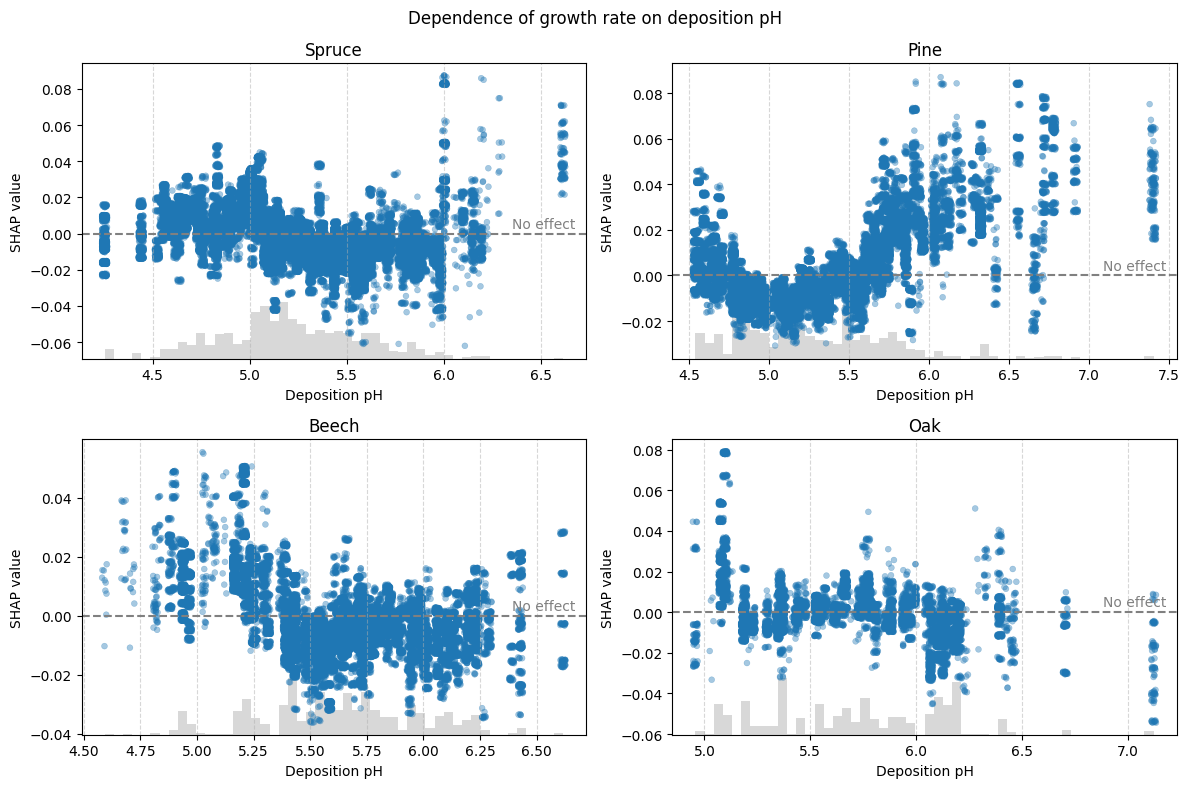

In [45]:
feature = "dep_ph"  # Change this to the feature you want to plot
# interacting = "dep_fe"
fit_curve = False
fold = 0

# One plot per species (4 in total)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for species, ax in zip(all_species, axes.flatten()):
    plot_dependence(
        all_results[species],
        feature=feature,
        fit_curve=fit_curve,
        ax=ax,
        alpha=0.4,
        # color=all_results[species].shap_values[fold][:, "dep_ph"].values
    )
    ax.set_title(species.capitalize())
    ax.set_xlabel("Deposition pH")
    ax.set_ylabel("SHAP value")


if fit_curve:
    fig.suptitle(f"Dependence plots for {feature} with power law fit (fold {fold})")
else:
    fig.suptitle("Dependence of growth rate on deposition pH")
plt.tight_layout()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

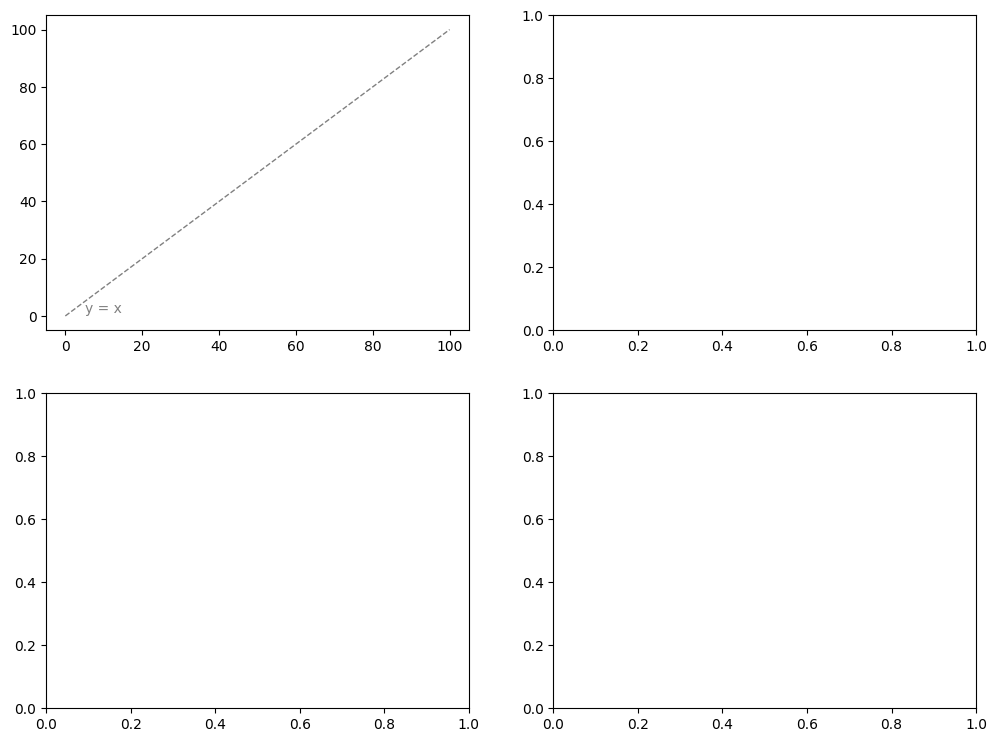

In [ ]:
from matplotlib.colors import TwoSlopeNorm
import matplotlib.cm as cm

# Overlay both mean and max defoliation on the same plot
fold = 0

# One plot per species (4 in total)
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

handles, labels = [], []
for species, ax in zip(all_species, axes.flatten()):
    data = all_results[species].get_data(fold=fold, split="all")[0]

    # Draw x = y line and a label
    ax.plot(
        [0, 100],
        [0, 100],
        color="grey",
        linestyle="--",
        linewidth=1,
    )
    ax.text(
        5,
        5,
        "y = x",
        color="grey",
        fontsize=10,
        ha="left",
        va="top",
    )

    # Plot mean vs max defoliation colored by Shapley values of both
    shap_values = (
        all_results[species].shap_values[fold][:, "defoliation_median"].values
        + all_results[species].shap_values[fold][:, "defoliation_max"].values
    )

    # Use coolwarm colormap for better visibility
    norm = TwoSlopeNorm(vmin=-0.30, vcenter=0, vmax=0.2)
    cmap = plt.get_cmap("coolwarm")
    colors = cmap(norm(shap_values))

    ax.scatter(
        data["defoliation_median"].to_numpy(),
        data["defoliation_max"].to_numpy(),
        # label="Mean defoliation",
        c=shap_values,
        alpha=0.8,
        s=15,
        cmap=cmap,
    )

    ax.set_xlabel("Median defoliation")
    ax.set_ylabel("Max defoliation")
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)

    # Compute R2 between mean and max defoliation
    r2 = (
        np.corrcoef(
            data["defoliation_median"].to_numpy(),
            data["defoliation_max"].to_numpy(),
        )[0, 1]
        ** 2
    )

    # Set the title with R2 value
    ax.set_title(
        f"{species.capitalize()} (R² = {r2:.2f})",
        fontsize=12,
    )

# Display colorbar
fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axes,
    # Draw the colorbar on the right side of the plot
    cax=fig.add_axes([1.01, 0.15, 0.02, 0.7]),
    label="Sum of SHAP values of median and max defoliation",
    orientation="vertical",
    use_gridspec=True,
)

# Set font size for the legend
fig.legend(handles, labels, fontsize=12)
fig.suptitle(
    f"Relation between median and max defoliation (fold {fold})",
    fontsize=16,
)

plt.tight_layout()

# Species-specific plots

Hereafter we investigate a specific species and feature.

In [ ]:
species: Species = "oak"
results = all_results[species]

## Feature interactions

We visualize the interaction between features by plotting two features against one each other.

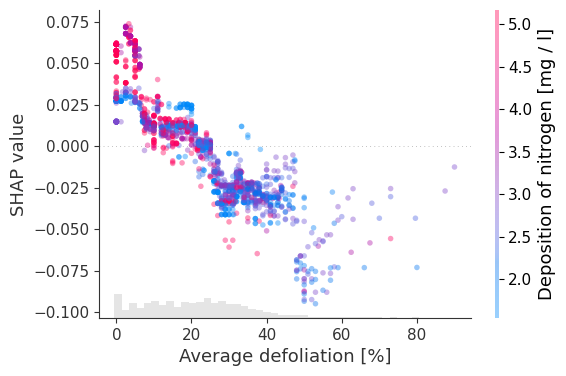

In [ ]:
feature = "defoliation_mean"  # Feature to plot
interacting = "dep_n_tot"

# Construct a DataFrame of the interaction values
feature_idx = results.X.columns.index(feature)

# Set axes
fig, ax = plt.figure(figsize=(6, 4)), plt.gca()

# Plot dependence plot with specific interaction
shap.plots.scatter(
    results.shap_values[fold][:, feature],
    color=results.shap_values[fold][:, interacting],
    # color=results.shap_values[fold],
    alpha=0.4,
    ax=ax,
    show=False,
)
plt.xlabel("Average defoliation [%]")
plt.ylabel("SHAP value")

# Set label of colorbar
ax.collections[0].colorbar.set_label("Deposition of nitrogen [mg / l]")

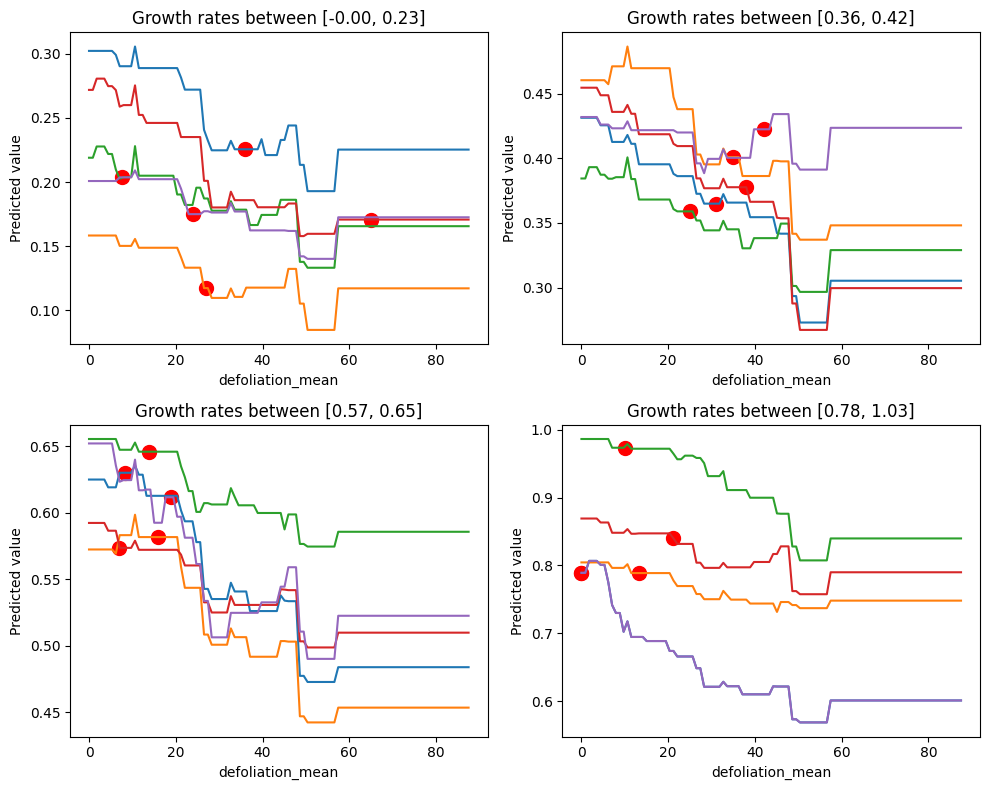

In [ ]:
from explain import plot_ceteris_paribus_profile

fold = 0

X, _, y_pred = results.get_data(fold, "test")

# Plot 4 profiles for the selected feature
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

y_vec = y_pred.to_numpy()

for i, ax in enumerate(axes.flat):
    if i == 0:
        # Take 5 growth rates in the 5th percentile
        low, high = np.min(y_vec), np.percentile(y_vec, 5)
    elif i == 1:
        # Take 5 growth rates in the [20, 30] percentile
        low, high = (
            np.percentile(y_vec, 20),
            np.percentile(y_vec, 35),
        )
    elif i == 2:
        # Take 5 growth rates in the [70, 80] percentile
        low, high = (
            np.percentile(y_vec, 70),
            np.percentile(y_vec, 80),
        )
    else:
        # Take 5 growth rates in the 95th percentile
        low, high = np.percentile(y_vec, 95), np.max(y_vec)

    plot_period_indices = np.random.choice(
        np.argwhere((y_vec >= low) & (y_vec < high)).flatten(),
        5,
    )
    title = f"Growth rates between [{low:.2f}, {high:.2f}]"

    for idx in plot_period_indices:
        feature_range, y_pred = plot_ceteris_paribus_profile(
            results.estimators[fold], X, idx, feature, ax=ax
        )
    ax.set_title(title)
    # ax.set_ylim([0.2, 0.8])

plt.tight_layout()

In [ ]:
# Use Shapley values to cluster the data

In [ ]:
# Visualize Shapley values using t-SNE
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Build a dataframe of shapley values across all species
df_shap = []
species_col = []
plot_id_col = []
for species, results in all_results.items():
    for fold in range(5):
        df_shap.append(results.shap_values[fold].values)
        species_col.extend([species] * len(df_shap[-1]))
        plot_id_col.extend(results.metadata["plot_id"].to_numpy())

# Build a dataframe of SHAP values, downsampled to 20,000 samples
df_shap = (
    pl.from_numpy(np.concatenate(df_shap, axis=0), schema=results.features)
    .with_columns(pl.Series("species", species_col), pl.Series("plot_id", plot_id_col))
    .select("species", "plot_id", pl.exclude("species", "plot_id"))
).sample(n=20000)

# Standardize the data
scaler = StandardScaler()
X_shap = np.nan_to_num(
    scaler.fit_transform(df_shap.select(pl.exclude("species")).to_numpy())
)

# Train the t-SNE model
tsne = TSNE(n_components=2, perplexity=100, early_exaggeration=20)
X_tsne = tsne.fit_transform(X_shap)

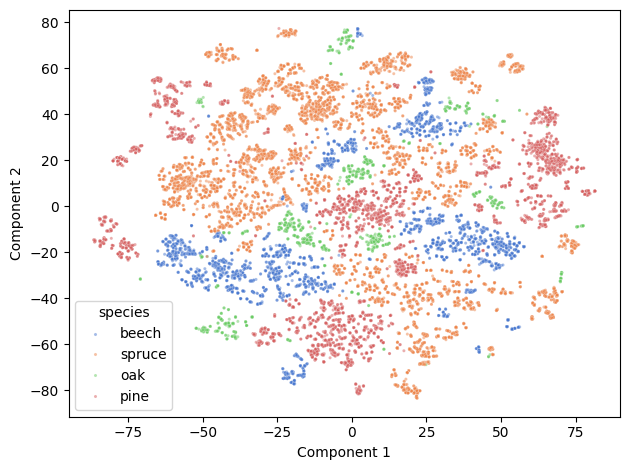

In [ ]:
# Use seaborn to generate a scatter plot of the t-SNE results
ax = sns.scatterplot(
    data=df_shap.with_columns(
        pl.Series("tsne_x", X_tsne[:, 0]), pl.Series("tsne_y", X_tsne[:, 1])
    ).to_pandas(),
    x="tsne_x",
    y="tsne_y",
    hue="species",
    alpha=0.5,
    palette="muted",
    s=5,
    legend="brief",
)

ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")

plt.tight_layout()

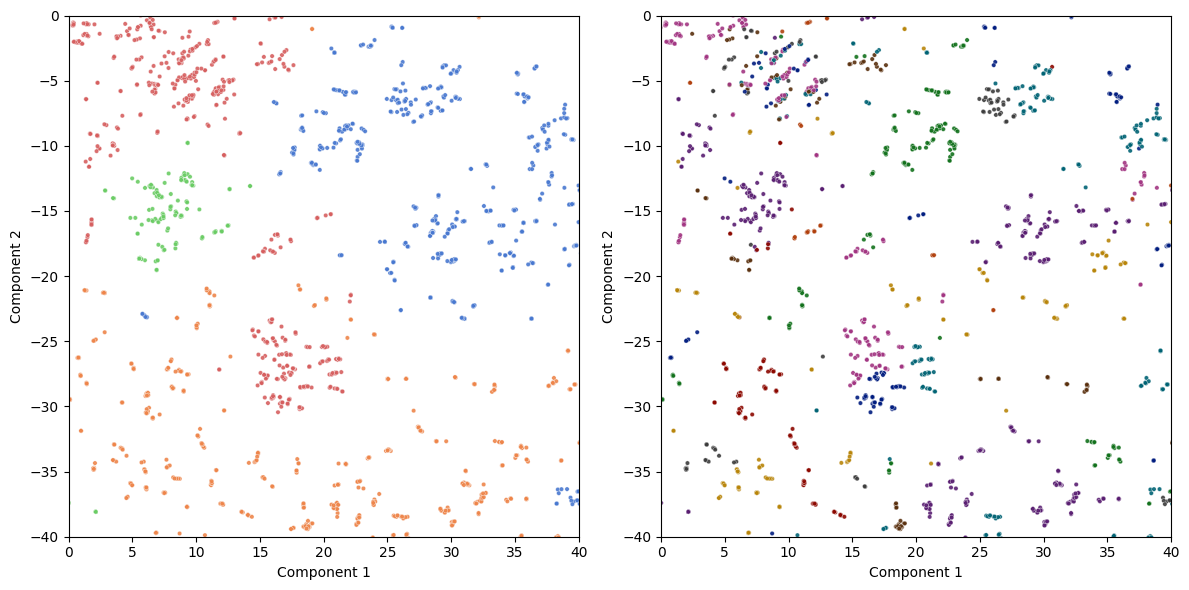

In [ ]:
# Produce a zoom in a specific region
x_bounds = [0, 40]
y_bounds = [-40, 0]

# Create 2 subplots of the zoomed region: one for the species and one for the plot_id

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, col in zip(axes, ["species", "plot_id"]):
    sns.scatterplot(
        data=df_shap.with_columns(
            pl.Series("tsne_x", X_tsne[:, 0]), pl.Series("tsne_y", X_tsne[:, 1])
        ).to_pandas(),
        x="tsne_x",
        y="tsne_y",
        hue=col,
        alpha=0.9,
        palette="muted" if col == "species" else "dark",
        legend=False,
        s=10,
        ax=ax,
    )

    ax.set_xlim(x_bounds)
    ax.set_ylim(y_bounds)

    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")

    plt.tight_layout()

## Feature interactions

We can compute the Shapley interactions using `get_shap_interactions`, which returns a tensor `(# samples, # features, # features)`, where each slice along the first axis is a symmetric matrix of interaction values, whose each row sums to the Shapley value for this feature. The diagonal entries represent the "main effect" attributed to that feature, whereas other entires represent the first-order interactions with every other feature.

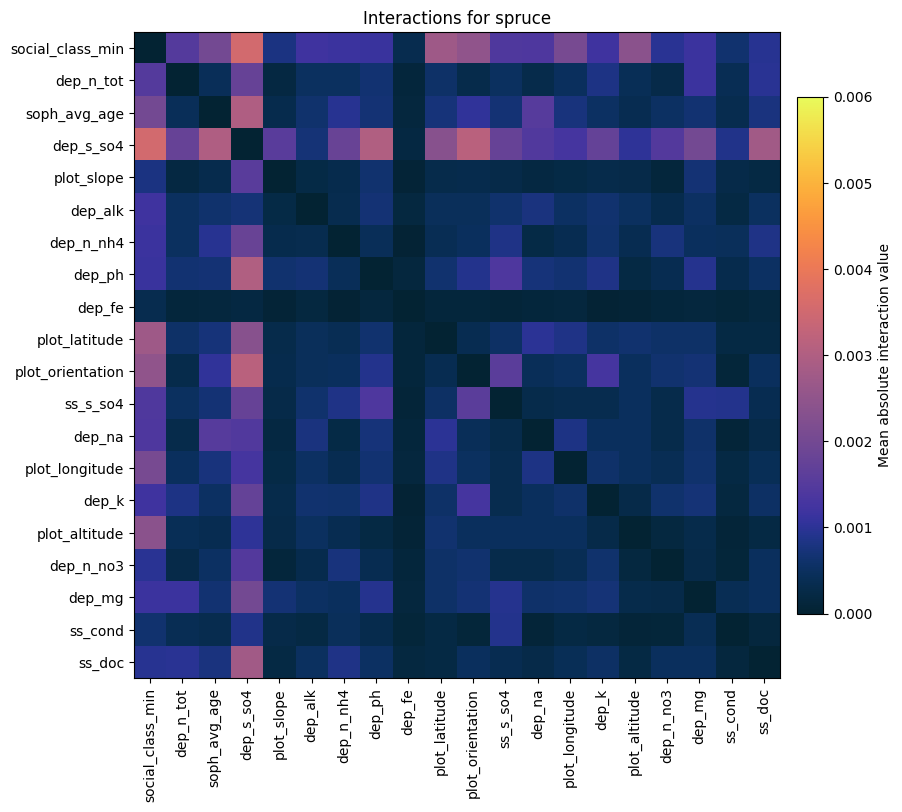

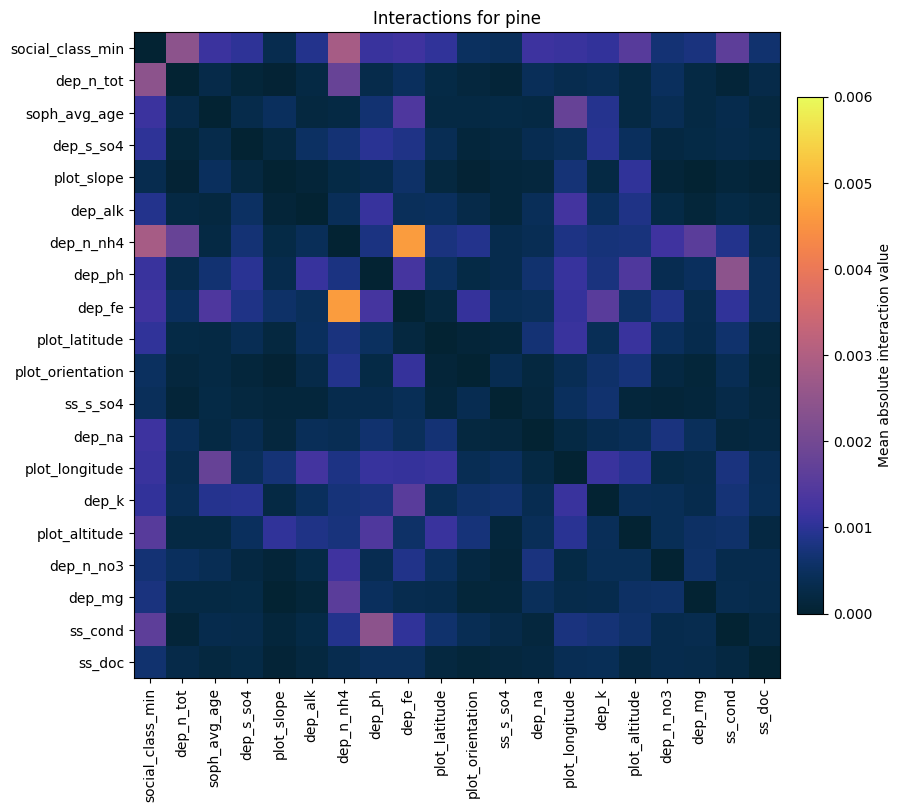

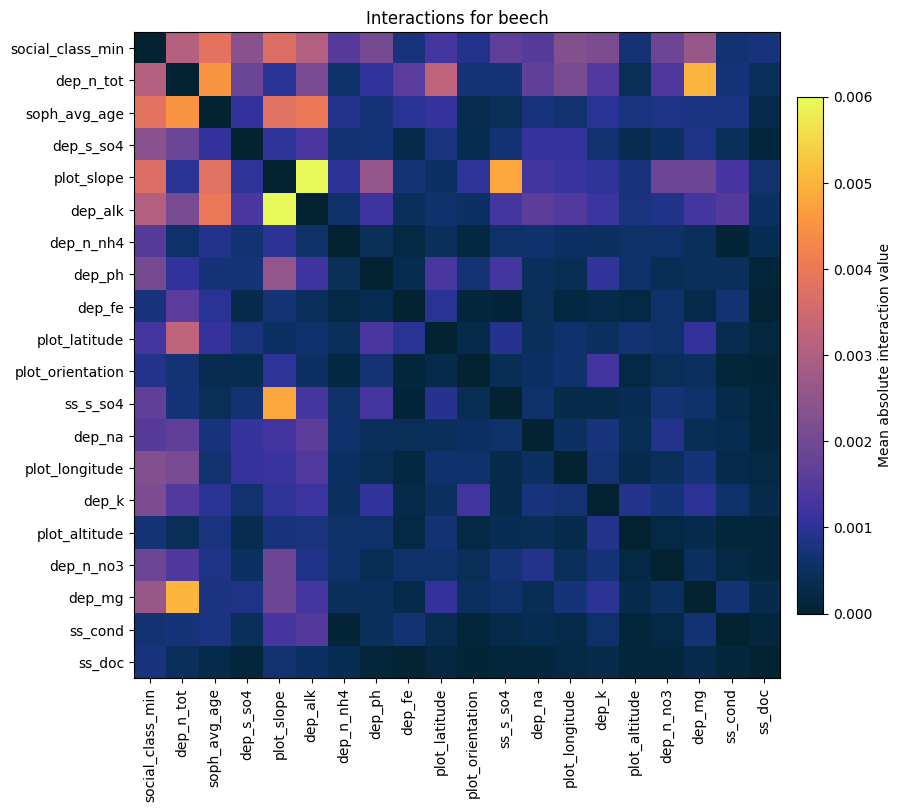

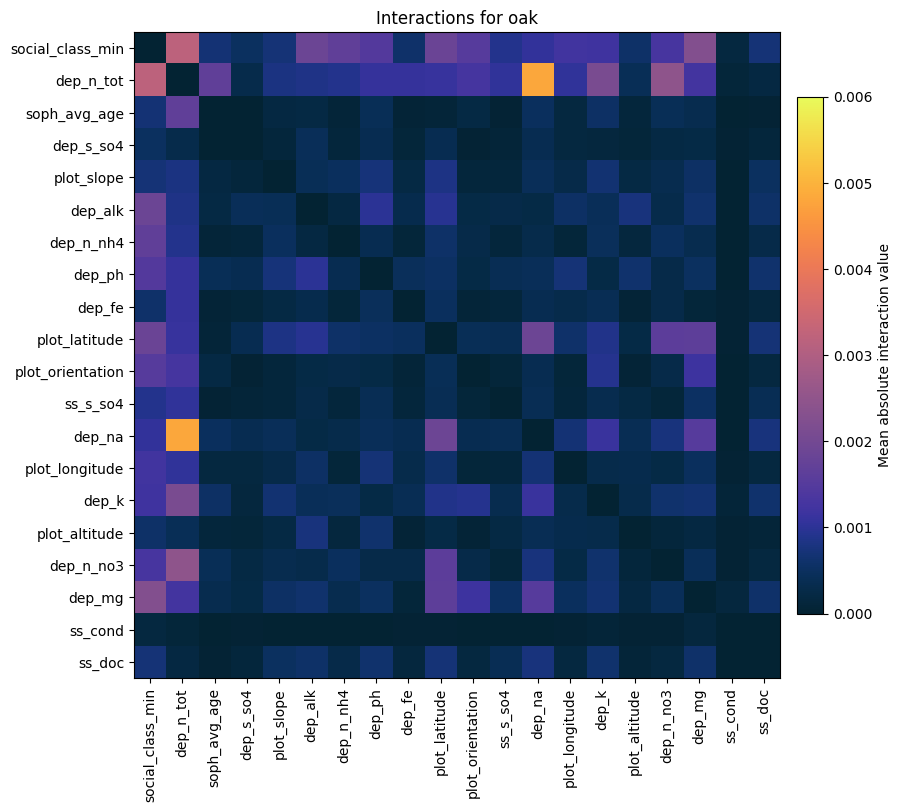

In [ ]:
from explain import compute_interaction_matrix

top_n_features = (
    feature_importances.select(
        "feature", pl.col("shap").mean().over("feature").alias("importance")
    )
    .unique()
    .sort("importance", descending=True)
    .head(20)["feature"]
    .to_list()
)

interactions = {}
indices = {}

# Loop over the species
for species in all_species:
    results = all_results[species]

    # Plot the mean absolute interaction values for the selected feature as a heatmap
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    interactions[species], indices[species] = compute_interaction_matrix(
        results, top_n=top_n_features, ax=ax, vmax=0.006
    )

    plt.tight_layout()
    plt.title(f"Interactions for {species}")

    plt.savefig(f"figures/{species}-interactions-mean.png")

Text(0.5, 1.0, 'Interaction graph for oak')

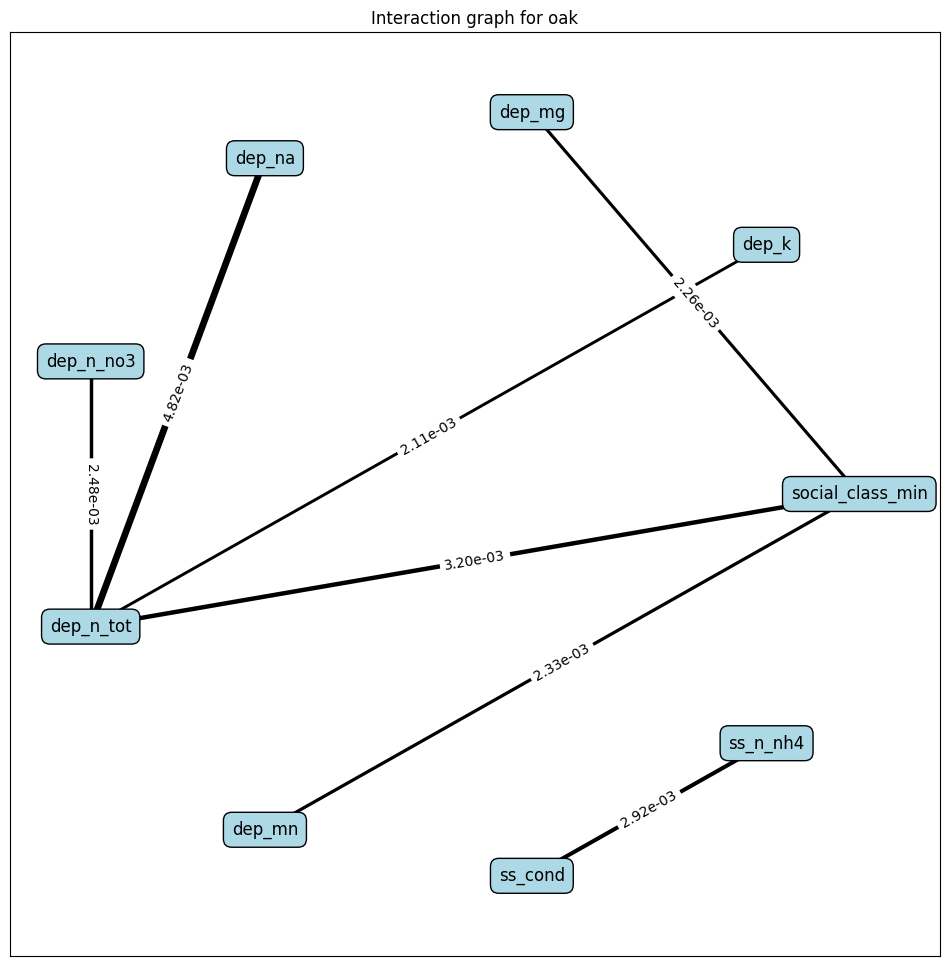

In [ ]:
import networkx as nx

# Find all pair of features with a significant interaction
species = "oak"
cutoff = 0.002

results = all_results[species]
interactions_matrix = interactions[species]

interactions_matrix = np.absolute(interactions_matrix).mean(axis=0)
adjacency_matrix = np.triu(interactions_matrix, k=1)
adjacency_matrix[adjacency_matrix < cutoff] = 0.0

# Build graph from adjacency matrix
G = cast(
    nx.Graph,
    nx.from_numpy_array(
        adjacency_matrix,
        edge_attr="interaction",
        nodelist=results.features,
    ),
)

# Trim nodes without any connection
G.remove_nodes_from(list(nx.isolates(G)))

# Display graph with a circular layout
plt.figure(figsize=(12, 12))
pos = nx.circular_layout(G)

# Draw edges with a width proportional to the interaction strength
nx.draw_networkx_edges(
    G, pos, width=[G[u][v]["interaction"] * 1000 for u, v in G.edges()]
)

# Draw labels for the edges up in scientific notation with 2 decimal places
edge_labels = {
    k: f"{v:.2e}" for k, v in nx.get_edge_attributes(G, "interaction").items()
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Draw labels for the nodes while avoiding overlap
nx.draw_networkx_labels(
    G,
    pos,
    font_size=12,
    font_color="black",
    bbox=dict(facecolor="lightblue", boxstyle="round,pad=0.5,rounding_size=0.5"),
)
plt.title(f"Interaction graph for {species}")

In [ ]:
len(results.features), interactions_matrix.shape

(68, (68, 68))